In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from keras.utils import np_utils
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from tensorflow.python.ops.numpy_ops.np_math_ops import log
import matplotlib.pyplot as plt
from functools import wraps
from time import time

print(tf.__version__)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

2.8.0


In [ ]:
def get_data():
  """
  Code copied from the link given in assignment description

  Returns
  -------
  tr_x : 60000,784 numpy array
  tr_y : 60000,10 numpy array
  te_x : 10000,784 numpy array
  te_y : 10000,10 numpy array
  
  """

  # load the training and test data    
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()
  
  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)

  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0

  print( "Shape of training features ", tr_x.shape)
  print( "Shape of test features ", te_x.shape)

  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  # tr_y = tr_y.T
  print ("Shape of training labels ", tr_y.shape)

  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  # te_y = te_y.T
  print ("Shape of testing labels ", te_y.shape)

  return tr_x, tr_y, te_x, te_y

The figure below is from the lecture notes, it is an example if one instance X with n features mutiplied with n weights, all these products are added and passed through an activation layer (layed 1 - ReLu and layer 2 SoftMax to generate output y_predicted)

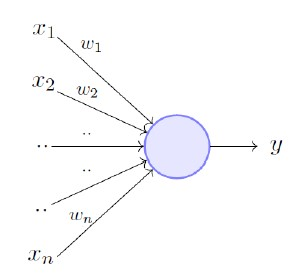

In [ ]:
def forward_pass(X, W1, B1, W2, B2):
  """ 
  Performs forward pass for the neural network
  
  Parameters
  ----------
  X : 60000,784 TensorFlow Variables of training data
  W1 : 200,784 TensorFlow Variables of layer 1 weights 
  B1 : 200,1 TensorFlow Variables of layer 1 bias
  W2 : 10,200 TensorFlow Variables of layer 2 weights 
  B2 : 10,1 TensorFlow Variables of layer 2 bias

  Returns
  -------
  A2 : 60000,10 tensorflow variables of softmax layer output, probabilities of 10 classes of 60000 images
  """

  Z1 = tf.matmul(X,tf.transpose(W1)) + B1
  A1 = Activation('relu')(Z1) #shape 60,000 X 200

  Z2 = tf.matmul(A1, tf.transpose(W2)) + B2 
  A2 = tf.exp(Z2)/tf.reduce_sum(tf.exp(Z2), axis=-1).reshape(Z2.shape[0],1)
  # print(tf.reduce_sum(A2, axis=-1)) # checking if the probabilities add to 1 on all rows
  return A2


Muticlass Cross Entropy loss L is given by

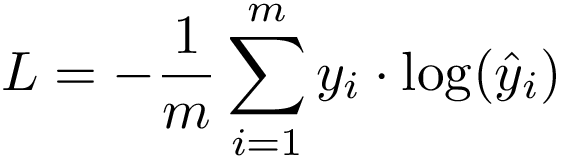


Where, 
yi is the ith instance true class lables,

y_cap_i is the ith predicted class probabilities,

m is the number of images in the dataset


In [ ]:
def cross_entropy(pred_y, true_y):
  """
  Performs Categorical Cross Entropy Loss calculation

  Parameters
  ----------
  pred_y : 60000,10 tensorflow variables from softmax layer - forward_pass()
  true_y : 60000,10 tensorflow variables of input image categorical lables 

  Returns
  -------
  loss : float32 value of Categorical Cross Entropy loss calculated as shown in the figure above
  """
  # cce = tf.keras.losses.CategoricalCrossentropy()
  # print("This is the loss from built in function", cce(true_y, pred_y).numpy())
  loss  = -tf.reduce_mean(tf.reduce_sum(true_y * (tf.math.log(pred_y)), axis=-1))
  return loss


In [ ]:
def calculate_accuracy(pred_y, true_y):
  """
  Calculate accuracy

  Parameters
  ----------
  pred_y : 60000,10 tensorflow variables from softmax layer - forward_pass()
  true_y : 60000,10 tensorflow variables of input image categorical lables 

  Returns
  -------
  acr : float32 value of Accuracy between predicted class and True class
  
    """
  pred_y = tf.round(pred_y)
  pred_correct = tf.cast(tf.equal(pred_y, true_y), tf.float32)
  acr = tf.reduce_mean(pred_correct)
  return acr

In [ ]:
#Copied from Quora answers - https://stackoverflow.com/questions/2245161/how-to-measure-execution-time-of-functions-automatically-in-python
def timed(f):
    wraps(f)
    def wrapper(*args, **kwargs):
        start_time = time()
        res = f(*args, **kwargs)
        elapsed = time() - start_time
        print ("Execution time for function {} is: {} seconds".format(f.__name__, elapsed))
        return res
    return wrapper


4431872/4422102 [==============================] - 0s 0us/step
Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (60000, 10)
Shape of testing labels  (10000, 10)
Iteration: 0, Loss: 2.471320867538452, Accuracy: 0.8999750018119812
Iteration: 1, Loss: 2.056964874267578, Accuracy: 0.9000066518783569
Iteration: 2, Loss: 1.799872636795044, Accuracy: 0.9001349806785583
Iteration: 3, Loss: 1.6302844285964966, Accuracy: 0.905144989490509
Iteration: 4, Loss: 1.4751839637756348, Accuracy: 0.9122849702835083
Iteration: 5, Loss: 1.3345261812210083, Accuracy: 0.9164450168609619
Iteration: 6, Loss: 1.218429446220398, Accuracy: 0.9207966923713684
Iteration: 7, Loss: 1.1222894191741943, Accuracy: 0.927216649055481
Iteration: 8, Loss: 1.0426650047302246, Accuracy: 0.9325266480445862
Iteration: 9, Loss: 0.9783334732055664, Accuracy: 0.9359583258628845
Iteration: 10, Loss: 0.927925705909729, Accuracy: 0.9385550022125244
Iteration: 11, Loss: 0.88734984

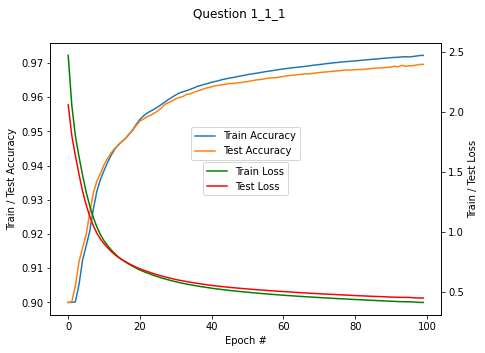

Execution time for function main is: 14.87847375869751 seconds


In [ ]:
@timed
def main():
  tf.random.set_seed(50)
  num_Iters = 500
  adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  train_loss, train_acc, test_loss, test_acc, epoc = [], [], [], [], []
  
  #get processed data from get_data()
  train_x, train_y, test_x, test_y = get_data()
  
  # Create tensorflow variables and change datatype to float64
  dt = tf.float32
  train_x = tf.cast(train_x, dt)
  train_y = tf.cast(train_y, dt)
  test_x = tf.cast(test_x, dt)
  test_y = tf.cast(test_y, dt)

  #when using RELU, multiply the weights with sqrt(2/n) to mitigate vanishing/exploding weights for large 'n' - Andrew Ng 
  W1 = tf.Variable(tf.random.normal([200,784]) * tf.sqrt(2/784))
  W2 = tf.Variable(tf.random.normal([10,200]) * tf.sqrt(2/200))
  B1 = tf.Variable(tf.zeros([1]))
  B2 = tf.Variable(tf.zeros([1]))
  
  for i in range(num_Iters):
    epoc.append(i)
    with tf.GradientTape() as tape:
      predicted_y = forward_pass(train_x, W1, B1, W2, B2)
      crossEntLoss = cross_entropy(predicted_y, train_y) # check this out 
      train_loss.append(crossEntLoss)
    gradients = tape.gradient(crossEntLoss,[W1, W2, B1, B2])
    accuracy = calculate_accuracy(predicted_y, train_y)
    train_acc.append(accuracy)
    print("Iteration: {}, Loss: {}, Accuracy: {}".format(i, crossEntLoss, accuracy))

    adam_optimizer.apply_gradients(zip(gradients,[W1, W2, B1, B2]))

    #test data - validate
    pred_y = forward_pass(test_x, W1, B1, W2, B2)
    loss = cross_entropy(pred_y, test_y)
    test_loss.append(loss)
    accuracy = calculate_accuracy(pred_y, test_y)
    test_acc.append(accuracy)

# plotting four curves - https://stackoverflow.com/questions/67248885/plot-four-curve-with-one-x-axis-and-2-different-y-axis-on-the-same-plot-in-pytho
  fig = plt.figure(figsize=(7,5))
  fig.suptitle("Question 1_1_1")
  ax1 = fig.add_subplot()
  ax2 = ax1.twinx()
  ax1.plot(epoc,train_acc, label = 'Train Accuracy')
  ax1.plot(epoc,test_acc, label = 'Test Accuracy')
  ax2.plot(epoc,train_loss, color='green', label = 'Train Loss')
  ax2.plot(epoc,test_loss, color='red', label = 'Test Loss')
  ax1.set_ylabel("Train / Test Accuracy")
  ax2.set_ylabel("Train / Test Loss")
  ax1.set_xlabel("Epoch #")
  ax1.legend(loc ='center', bbox_to_anchor=(0.5, 0.63))
  ax2.legend(loc= 'center', bbox_to_anchor=(0.5, 0.5))
  plt.show()

if __name__ == "__main__":
    main()